<a href="https://colab.research.google.com/github/saif9402/Dr-Wessam-Project/blob/main/Count_Vectorizer_Feature_Extarction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"seifmohamedmamdouh","key":"8f063499136ccdd1a9cdf14264e78ce8"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
# Make sure you specify the correct dataset slug
!kaggle datasets download -d anupampaul005/fake-news-dataset

Dataset URL: https://www.kaggle.com/datasets/anupampaul005/fake-news-dataset
License(s): MIT
 92% 74.0M/80.4M [00:00<00:00, 751MB/s]
100% 80.4M/80.4M [00:00<00:00, 637MB/s]


In [4]:
!unzip -o fake-news-dataset.zip

Archive:  fake-news-dataset.zip
  inflating: dataset.csv             


In [7]:
import pandas as pd
import re, string, nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [8]:
nltk.download('stopwords')
nltk.download('wordnet')

df = pd.read_csv('dataset.csv')
df['content'] = df['title'].fillna('') + ' ' + df['text'].fillna('')
df['label'] = df['unreliable']
# Check result
print(df[['title', 'text', 'content', 'label']].head())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


                                               title  \
0  WARNING: A Pivotal Moment For The Stock Market...   
1  Trump, top defense officials, discuss North Ko...   
2  British civil servants' union calls nationwide...   
3   A**hole Of The Day – Michele Bachmann: Muslim...   
4  ’Deport Fat People’ Posters Appear At CU Bould...   

                                                text  \
0  WARNING: A Pivotal Moment For The Stock Market...   
1  WASHINGTON  - U.S. President Donald Trump met ...   
2  LONDON  - British civil servants will vote nex...   
3  Michele Bachmann has been pretty quiet since l...   
4  Posters calling on Donald Trump to “Deport Fat...   

                                             content  label  
0  WARNING: A Pivotal Moment For The Stock Market...      1  
1  Trump, top defense officials, discuss North Ko...      0  
2  British civil servants' union calls nationwide...      0  
3   A**hole Of The Day – Michele Bachmann: Muslim...      1  
4  ’Deport Fat P

In [9]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    text = text.lower()
    text = re.sub(f"[{string.punctuation}]", "", text)
    text = re.sub(r'\d+', '', text)
    words = [w for w in text.split() if w not in stop_words]
    words = [lemmatizer.lemmatize(w) for w in words]
    return ' '.join(words)

In [10]:
df['cleaned_content'] = df['content'].apply(preprocess)

# 🌟 STEP 9: Remove short documents (<5 words)
df = df[df['cleaned_content'].str.split().str.len() > 5]

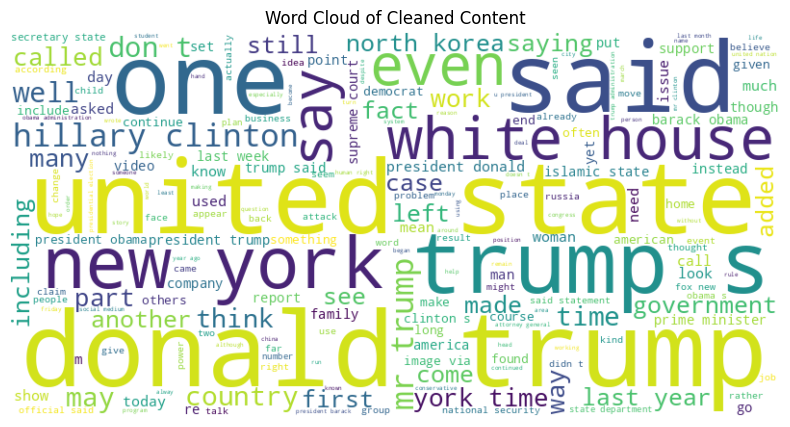

In [11]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = " ".join(df['cleaned_content'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Cleaned Content")
plt.show()


In [12]:
# ---------------------- Data Splitting ----------------------
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
# Drop rows with missing text or label
df = df.dropna(subset=['cleaned_content', 'label'])

X = df['cleaned_content']
y = df['label']
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)


# ---------------------- Count Vectorizer ----------------------
vectorizer = CountVectorizer(max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_val_vec = vectorizer.transform(X_val)
X_test_vec = vectorizer.transform(X_test)

In [13]:
def plot_confusion(y_true, y_pred, title="Confusion Matrix"):


    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(title)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()


Logistic Regression Evaluation Metrics:
Training Accuracy: 0.999974569590316
Testing Accuracy: 0.9472078120231919
Precision: 0.9420695754716981
Recall: 0.955306427503737
F1 Score: 0.9486418287071396
Confusion Matrix:
 [[6025  393]
 [ 299 6391]]


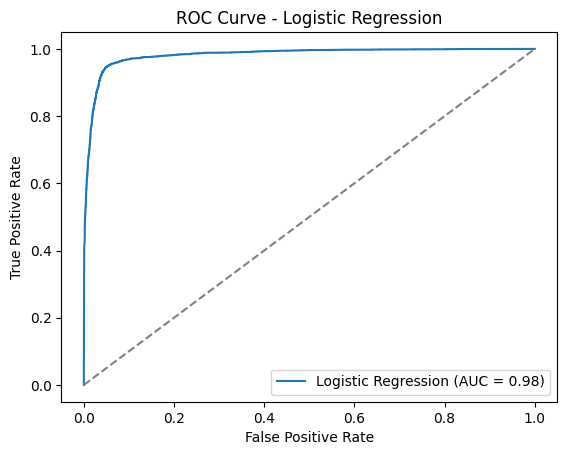

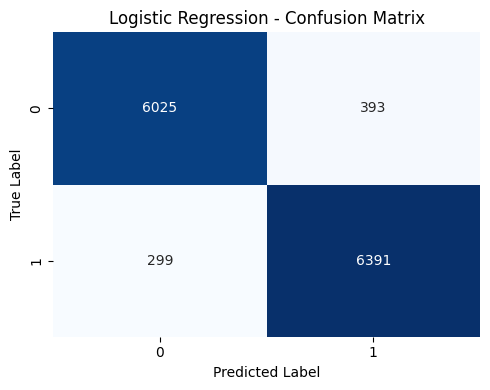

In [15]:
#logistec regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, auc
)
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

log_model = LogisticRegression(C=10, class_weight=None, penalty='l2', solver='lbfgs', max_iter=1000)
log_model.fit(X_train_vec, y_train)

# Predict probabilities and labels
log_probs = log_model.predict_proba(X_test_vec)[:, 1]
log_preds = log_model.predict(X_test_vec)
train_preds = log_model.predict(X_train_vec)

# Evaluation metrics
print("\nLogistic Regression Evaluation Metrics:")
print("Training Accuracy:", accuracy_score(y_train, train_preds))
print("Testing Accuracy:", accuracy_score(y_test, log_preds))
print("Precision:", precision_score(y_test, log_preds))
print("Recall:", recall_score(y_test, log_preds))
print("F1 Score:", f1_score(y_test, log_preds))
print("Confusion Matrix:\n", confusion_matrix(y_test, log_preds))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, log_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend(loc='lower right')
plt.show()

    # Plot Confusion Matrix
cm = confusion_matrix(y_test, log_preds)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Logistic Regression - Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


Random Forest Evaluation Metrics:
Training Accuracy: 0.9996439742644254
Testing Accuracy: 0.9595666768385719
Precision: 0.9716692189892803
Recall: 0.9484304932735426
F1 Score: 0.959909228441755
Confusion Matrix:
 [[6233  185]
 [ 345 6345]]


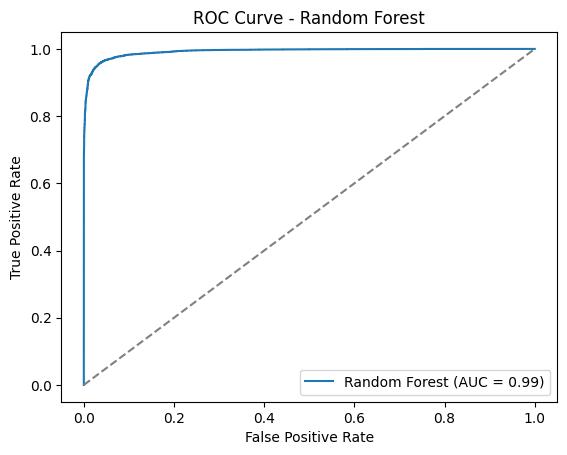

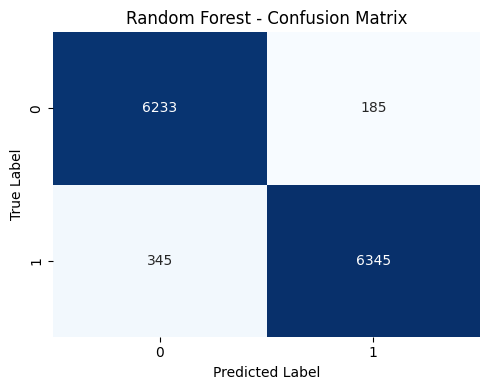

In [17]:
#Random Forest

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, auc
)
import matplotlib.pyplot as plt

# Train the Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=50,
    max_features='sqrt',
    min_samples_split=2,
    min_samples_leaf=1,
    class_weight=None,
    random_state=42
)
rf_model.fit(X_train_vec, y_train)

# Predict probabilities and labels
rf_probs = rf_model.predict_proba(X_test_vec)[:, 1]
rf_preds = rf_model.predict(X_test_vec)
rf_train_preds = rf_model.predict(X_train_vec)

# Evaluation metrics
print("\nRandom Forest Evaluation Metrics:")
print("Training Accuracy:", accuracy_score(y_train, rf_train_preds))
print("Testing Accuracy:", accuracy_score(y_test, rf_preds))
print("Precision:", precision_score(y_test, rf_preds))
print("Recall:", recall_score(y_test, rf_preds))
print("F1 Score:", f1_score(y_test, rf_preds))
print("Confusion Matrix:\n", confusion_matrix(y_test, rf_preds))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, rf_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label='Random Forest (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend(loc='lower right')
plt.show()

    # Plot Confusion Matrix
cm = confusion_matrix(y_test, rf_preds)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Random Forest - Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:42:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost Evaluation Metrics:
Training Accuracy: 0.9929557765175597
Testing Accuracy: 0.9685688129386634
Precision: 0.9690675433353257
Recall: 0.9693572496263079
F1 Score: 0.9692123748318637
Confusion Matrix:
 [[6211  207]
 [ 205 6485]]


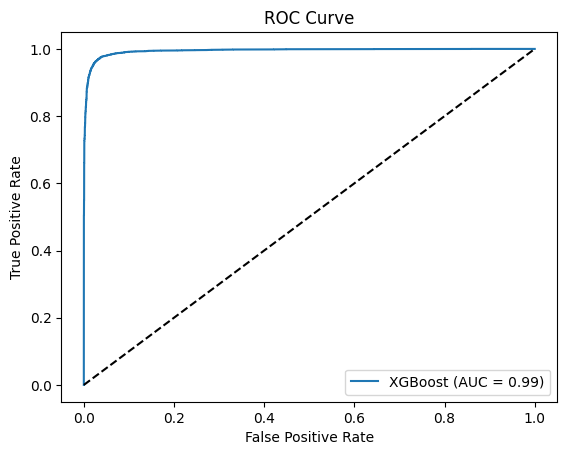

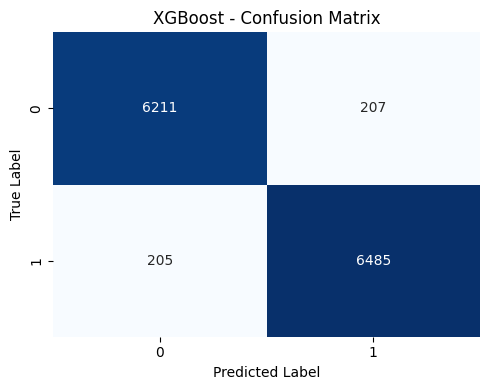

In [20]:
#XGBoost

from xgboost import XGBClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train_vec, y_train)

# Predict on Training and Testing Sets
y_train_pred = model.predict(X_train_vec)
y_test_pred = model.predict(X_test_vec)
y_test_prob = model.predict_proba(X_test_vec)[:, 1]

# Metrics
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)
roc_auc = roc_auc_score(y_test, y_test_prob)

print("\nXGBoost Evaluation Metrics:")
print("Training Accuracy:", accuracy_score(y_train, y_train_pred))
print("Testing Accuracy:", accuracy_score(y_test, y_test_pred))
print("Precision:", precision_score(y_test, y_test_pred))
print("Recall:", recall_score(y_test, y_test_pred))
print("F1 Score:", f1_score(y_test, y_test_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))

fpr, tpr, _ = roc_curve(y_test, y_test_prob)
plt.plot(fpr, tpr, label="XGBoost (AUC = {:.2f})".format(roc_auc_score(y_test, y_test_prob)))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

    # Plot Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("XGBoost - Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

In [5]:
!pip install tensorflow

In [6]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
1229/1229 ━━━━━━━━━━━━━━━━━━━━ 159s 127ms/step - accuracy: 0.7371 - loss: 0.5048 - val_accuracy: 0.8933 - val_loss: 0.2927
Epoch 2/10
1229/1229 ━━━━━━━━━━━━━━━━━━━━ 200s 125ms/step - accuracy: 0.8921 - loss: 0.2933 - val_accuracy: 0.9226 - val_loss: 0.2191
Epoch 3/10
1229/1229 ━━━━━━━━━━━━━━━━━━━━ 202s 126ms/step - accuracy: 0.9358 - loss: 0.1924 - val_accuracy: 0.8810 - val_loss: 0.3605
Epoch 4/10
1229/1229 ━━━━━━━━━━━━━━━━━━━━ 199s 123ms/step - accuracy: 0.9075 - loss: 0.2522 - val_accuracy: 0.9371 - val_loss: 0.1862
Epoch 5/10
1229/1229 ━━━━━━━━━━━━━━━━━━━━ 203s 125ms/step - accuracy: 0.9445 - loss: 0.1660 - val_accuracy: 0.9522 - val_loss: 0.1345
Epoch 6/10
1229/1229 ━━━━━━━━━━━━━━━━━━━━ 146s 119ms/step - accuracy: 0.9711 - loss: 0.1031 - val_accuracy: 0.9569 - val_loss: 0.1299
Epoch 7/10
1229/1229 ━━━━━━━━━━━━━━━━━━━━ 226s 138ms/step - accuracy: 0.9776 - loss: 0.0772 - val_accuracy: 0.9618 - val_loss: 0.1290
Epoch 8/10
1229/1229 ━━━━━━━━━━━━━━━━━━━━ 159s 129ms/step - ac

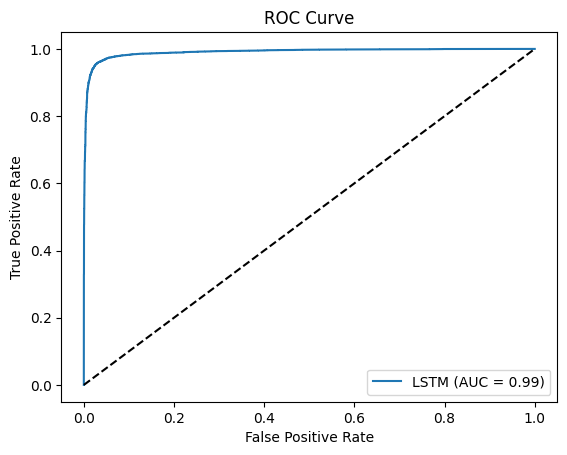

In [22]:
# ------------------ LSTM Model ------------------
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
max_len = 200

def prepare_lstm_data(X):
    return pad_sequences(tokenizer.texts_to_sequences(X), maxlen=max_len, padding='post')

X_train_pad = prepare_lstm_data(X_train)
X_val_pad = prepare_lstm_data(X_val)
X_test_pad = prepare_lstm_data(X_test)

lstm_model = Sequential([
    Embedding(5000, 64, input_length=max_len),
    LSTM(64),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_model.fit(X_train_pad, y_train, validation_data=(X_val_pad, y_val), epochs=10, batch_size=32, callbacks=[EarlyStopping(patience=3)])

from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import numpy as np

# Predict
y_train_pred_prob = lstm_model.predict(X_train_pad)
y_test_pred_prob = lstm_model.predict(X_test_pad)

# Convert probabilities to class labels
y_train_pred = (y_train_pred_prob > 0.5).astype(int)
y_test_pred = (y_test_pred_prob > 0.5).astype(int)

# Training Accuracy
train_acc = accuracy_score(y_train, y_train_pred)
# Testing Accuracy
test_acc = accuracy_score(y_test, y_test_pred)
# Recall
recall = recall_score(y_test, y_test_pred)
# F1 Score
f1 = f1_score(y_test, y_test_pred)
# AUC
auc = roc_auc_score(y_test, y_test_pred_prob)

# Print metrics
print(f"LSTM → Training Accuracy: {train_acc:.4f}")
print(f"LSTM → Testing Accuracy: {test_acc:.4f}")
print(f" Recall: {recall:.4f}")
print(f" F1 Score: {f1:.4f}")
print(f" AUC Score: {auc:.4f}")
print("\n Classification Report:\n", classification_report(y_test, y_test_pred))
print(" Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_test_pred_prob)
plt.plot(fpr, tpr, label="LSTM (AUC = {:.2f})".format(auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


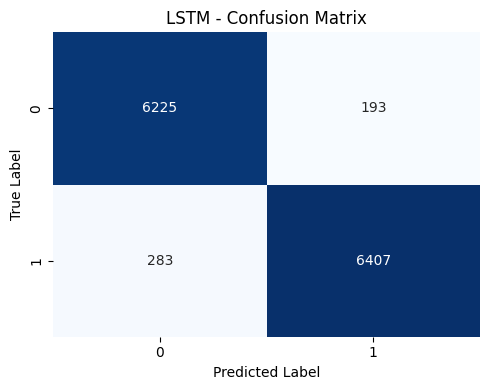

In [23]:
# prompt: plot of the confusion matrix of LSTM

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming y_test and y_test_pred are defined from your LSTM model
# Example:
# y_test_pred = (lstm_model.predict(X_test_pad) > 0.5).astype(int)

cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("LSTM - Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()
